## Phosphorus-based anodes for potassium-ion batteries: insights from computational structure prediction

### Summary

In this project I've done some structure prediction on the K-P phase diagram (as part of the ternary K-Sn-P). First I took the experimental phases from the ISCD (via our copy of the OQMD) and relaxed them with reasonably low accuracy (PBE, 300 eV, 0.07 1/Å kpoint spacing). Then I took all known [I]-[VI] binary compounds and "swapped" them to K-P using matador, relaxing those too. Then I ran some AIRSS (with pyairss), followed by evolutionary searches (with ilustrado) before "polishing" all structures that were found to be less than 100 meV/atom away from the rough convex hull. These calculations were ran with CASTEP OTF pseudopotentials, improved kpoints spacing (0.03 1/Å) and low force tolerances (0.01 -> 0.0001 eV/Å). The results are shown in the plots below.

Under PBE, the ICSD phase of K<sub>3</sub>P is found to be unstable, but lies very close to the hull. Likewise the often observed electrochemical endpoint K<sub>4</sub>P<sub>3</sub> is close to being stable, but is knocked off the hull by a swap phase of K<sub>5</sub>P<sub>4</sub> that no-one else has reported. We find some new phases with low K content, e.g. K<sub>3</sub>P<sub>11</sub> and K<sub>3</sub>P<sub>7</sub>, though they are less interesting in a battery context. Importantly, we predict several new phases that are at the same energy as the ICSD K<sub>3</sub>P, which may explain why no-one has seen it.

Since our predicted theoretical capacity of the battery depends entirely on the stable phases, I set out to try to include the fact that K<sub>3</sub>P is so close to the hull. In doing so, I ended up implementing the Bayesian Error Estimate Functional (BEEF) in CASTEP (not merged into the main release yet), which provides a way to assess the uncertainty in standard DFT calculations by creating an ensemble of randomly perturbed xc-functionals that are evaluated non-self-consistently on the PBE ground state geometries. The PBE-BEEF hull and the more advanced meta-GGA mBEEF-vdW hull (computed with GPAW on the PBE structures) are found below, and show the probability of different phases forming across the hulls generated with the ensemble of functionals.

Just recently I've also rerun the calculations with the rSCAN functional in the development version of CASTEP. This meta-GGA functional has been shown to perform better than PBE for formation energies at approximately double the computational cost. Phonon calculations across the entire hull have proved slightly tricky due to various reasons, but are nearly completed for the new phases. The aim was to make a finite temperature convex hull, but the instability of phosphorus under PBE makes it difficult. The ICSD K<sub>3</sub>P phase is shown to be dynamically unstable, unlike the new phases we are predicting.

#### BEEF papers:

1. Mortensen, J. J.; Kaasbjerg, K.; Frederiksen, S. L.; Nørskov, J. K.; Sethna, J. P.; Jacobsen, K. W. Bayesian Error Estimation in Density-Functional Theory. Physical Review Letters 2005, 95 (21). https://doi.org/10.1103/PhysRevLett.95.216401.  
2. Lundgaard, K. T.; Wellendorff, J.; Voss, J.; Jacobsen, K. W.; Bligaard, T. MBEEF-VdW: Robust Fitting of Error Estimation Density Functionals. Phys. Rev. B 2016, 93 (23), 235162. https://doi.org/10.1103/PhysRevB.93.235162.

#### SCAN papers

3. Bartók, A. P.; Yates, J. R. Regularized SCAN Functional. J. Chem. Phys. 2019, 150 (16), 161101. https://doi.org/10/gf8j2p.  
4. Sun, J.; Remsing, R. C.; Zhang, Y.; Sun, Z.; Ruzsinszky, A.; Peng, H.; Yang, Z.; Paul, A.; Waghmare, U.; Wu, X.; et al. Accurate First-Principles Structures and Energies of Diversely Bonded Systems from an Efficient Density Functional. Nature Chemistry 2016, 8 (9), 831–836. https://doi.org/10/f85xq7.


### Useful battery papers on K-P:

5. Wu, Y.; Huang, H.-B.; Feng, Y.; Wu, Z.-S.; Yu, Y. The Promise and Challenge of Phosphorus-Based Composites as Anode Materials for Potassium-Ion Batteries. Advanced Materials 0 (0), 1901414. https://doi.org/10/gf7hxn.  
6. Zhang, W.; Pang, W. K.; Sencadas, V.; Guo, Z. Understanding High-Energy-Density Sn4P3Anodes for Potassium-Ion Batteries. Joule 2018, 1–14. https://doi.org/10/gf2547.  
7. Kubota, K.; Dahbi, M.; Hosaka, T.; Kumakura, S.; Komaba, S. Towards K-Ion and Na-Ion Batteries as “Beyond Li-Ion.” The Chemical Record 2018, 1–22. https://doi.org/10/gf255b.  
8. Kim, H.; Kim, J. C.; Bianchini, M.; Seo, D.-H.; Rodriguez-Garcia, J.; Ceder, G. Recent Progress and Perspective in Electrode Materials for K-Ion Batteries. Advanced Energy Materials 2018, 8 (9), 1702384. https://doi.org/10/gdf3xg.  
9. Sultana, I.; Rahman, M. M.; Ramireddy, T.; Chen, Y.; Glushenkov, A. M. High Capacity Potassium-Ion Battery Anodes Based on Black Phosphorus. J. Mater. Chem. A 2017. https://doi.org/10/gf25z2.  
10. Zhang, W.; Mao, J.; Li, S.; Chen, Z.; Guo, Z. Phosphorus-Based Alloy Materials for Advanced Potassium-Ion Battery Anode. Journal of the American Chemical Society 2017, 139 (9), 3316–3319. https://doi.org/10/f9r2p9.

In [44]:
import tqdm
import glob
import pickle

import numpy as np    
import matplotlib.pyplot as plt
%matplotlib inline

from matador.config.config import set_settings
set_settings(
    {
        'mongo': {
            'host': "localhost",
            "port": 27017,
            "db": "crystals"
        },
        'plotting': {
            'element_colours': './config/vesta_elements.ini',
            'default_style': ['matador', './config/KP.mplstyle']
        }
    }
)
from matador.query import DBQuery
from matador.hull import QueryConvexHull
from matador.hull import EnsembleHull
from matador.scrapers import castep2dict, res2dict, bands2dict
from matador.utils.cursor_utils import filter_unique_structures, display_results
from matador.crystal import Crystal
from matador.utils.cell_utils import standardize_doc_cell, get_spacegroup_spg, get_space_group_label_latex
from matador.utils.chem_utils import get_formula_from_stoich
from matador.hull.hull_temperature import TemperatureDependentHull 
from matador.orm.spectral import VibrationalDOS, ElectronicDispersion
import matador.plotting

### Stability & voltage curves for PBE vs rSCAN

#### PBE

In [5]:
pbe_cursor, s = res2dict(
    "/home/mevans/proj/KPX/K+P/results/KP-650-0.03-1.75-1.75-PBE-OTF-0.01-polish/*.res", 
    db=True, 
    as_model=True
)

Successfully scraped 1820 out of 1820 files.


In [7]:
# filter for uniqueness, with tight energy tolerance
filtering = False
if filtering:
    polished_cursor = filter_unique_structures(pbe_cursor, energy_tol=1e-4, quiet=True, per_atom=True)
else:
    polished_cursor = pbe_cursor

# do some pruning: reevaluate symmetries and reduce cells
polished_cursor = [Crystal(standardize_doc_cell(doc)) for doc in polished_cursor]

In [8]:
pbe_hull = QueryConvexHull(
    cursor=polished_cursor,
    species=["K", "P"],
    voltage=True,
    hull_cutoff=0.01,
    volume=True,
    no_plot=True
)

114 structures found within 0.01 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                Source                 !?!  Pressure  Cell volume      Hull dist.      Space group      Formula      # fu   Prov.  
                                             (GPa)      (Å³/fu)        (meV/atom)    
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* K-CollCode44670                               0.02         73.3           0.0           Im-3m            K          1      ICSD  
  KP-GA-0ss21w-8x22                            -0.00        145.5           5.9            Pm             K3P         4       GA   
  KP-GA-0ss21w-8x53                            -0.01        145.6           5.9            Pm             K3P         4       GA   
  K3P-mode-follow-swap-Na3N-OQMD[..]      

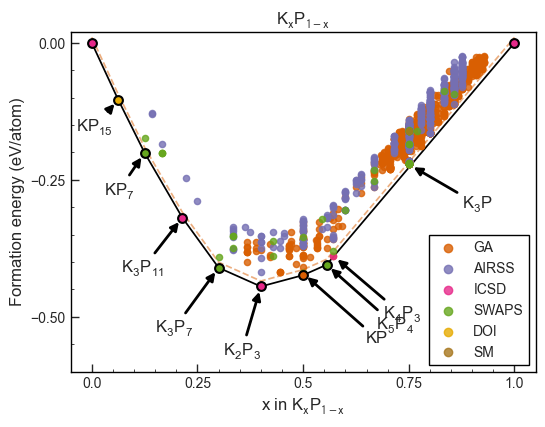

In [10]:
import matplotlib.pyplot as plt
from matador.plotting import plot_2d_hull
fig, ax = plt.subplots()
plot_2d_hull(
    pbe_hull,
    ax=ax,
    label_cutoff=0.008,
    colour_by_source=True,
    plot_hull_points=False,
    show=False,
    label_offset=(1.2, 0.04),
    eform_limits=(-0.6, 0.02),
    alpha=0.8,
    sources=["GA", "AIRSS", "ICSD", "SWAPS", "DOI", "SM", "OQMD"],
    source_labels=["GA", "AIRSS", "ICSD", "SWAPS", "DOI", "SM", "OQMD"]
)
ax.tick_params(direction='in')
ax.legend(loc='lower right');

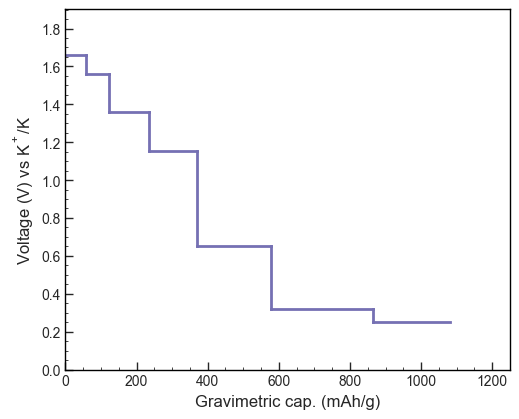

In [11]:
from matador.plotting import plot_voltage_curve
fig, ax = plt.subplots(figsize=(5, 4))
plot_voltage_curve(pbe_hull.voltage_data, ax=ax)

#### rSCAN

In [12]:
scan_cursor, s = res2dict(
    "/home/mevans/proj/KPX/K+P/results/KP-650-0.03-1.75-1.75-rSCAN-OTF-0.01-polish/*.res",
    db=True, 
    as_model=True
)
scan_hull = QueryConvexHull(cursor=scan_cursor, species="KP", subcmd='voltage', no_plot=True)

/home/mevans/proj/KPX/K+P/results/KP-650-0.03-1.75-1.75-rSCAN-OTF-0.01-polish/KP-6nhfxt.res: <class 'RuntimeError'> missing some TITL info
Successfully scraped 356 out of 357 files.
10 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                Source                 !?!  Pressure  Cell volume      Hull dist.      Space group      Formula      # fu   Prov.  
                                             (GPa)      (Å³/fu)        (meV/atom)    
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* K-CollCode44670                              -0.00         79.3           0.0           Im-3m            K          1      ICSD  
* K3P-mode-follow-swap-Na3N-OQMD[..]            0.00        139.8           0.0            P1             K3P         6     SW

/home/mevans/src/matador/matador/hull/hull.py:85: UserWarning: subcmd will soon be deprecated, please pass the equivalent flag as a kwarg (e.g. voltage=True)
  warnings.warn("subcmd will soon be deprecated, please pass the equivalent flag as a kwarg (e.g. voltage=True)")


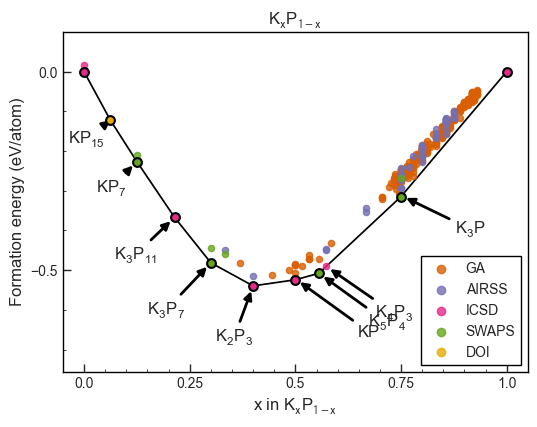

In [13]:
fig, ax = plt.subplots()
plot_2d_hull(
    scan_hull,
    ax=ax,
    label_cutoff=0.008,
    colour_by_source=True,
    plot_hull_points=False,
    show=False,
    label_offset=(1.2, 0.04),
    #eform_limits=(-0.6, 0.02),
    alpha=0.8,
    sources=["GA", "AIRSS", "ICSD", "SWAPS", "DOI", "SM", "OQMD"],
    source_labels=["GA", "AIRSS", "ICSD", "SWAPS", "DOI", "SM", "OQMD"]
)
ax.tick_params(direction='in')
ax.legend(loc='lower right');

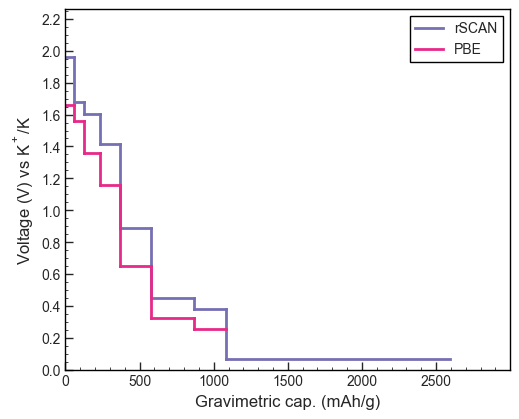

In [14]:
from matador.plotting import plot_voltage_curve
fig, ax = plt.subplots(figsize=(5, 4))
plot_voltage_curve(
    [scan_hull.voltage_data[0], pbe_hull.voltage_data[0]], 
    curve_labels=["rSCAN", "PBE"],
    ax=ax
)

#### rSCAN vs PBE

In [13]:
combined_cursor = []
for doc in pbe_hull.cursor:
    for _doc in scan_hull.cursor:
        if doc.root_source == _doc.root_source:
            doc["rscan_formation_enthalpy_per_atom"] = _doc["formation_enthalpy_per_atom"]
            combined_cursor.append(doc)
    

NameError: name 'pbe_hull' is not defined

In [16]:
from matador.utils.cursor_utils import get_array_from_cursor
pbe_ef = get_array_from_cursor(combined_cursor, "formation_enthalpy_per_atom")
scan_ef = get_array_from_cursor(combined_cursor, "rscan_formation_enthalpy_per_atom")
comp = get_array_from_cursor(combined_cursor, "concentration")
ef_diff = pbe_ef - scan_ef

NameError: name 'comp' is not defined

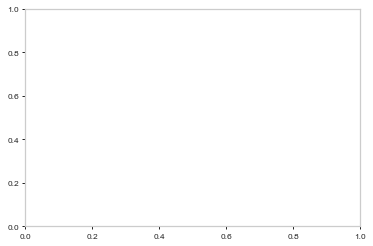

In [43]:
fig, ax = plt.subplots()
ax.scatter(comp, ef_diff, alpha=0.3, facecolor="None", edgecolor="r")
ax.set_xlabel("$x$ in K$_x$P")
ax.set_ylabel("$E_F^{PBE} - E_F^{SCAN}$")

## Finite temperature stability

In [6]:
from matador.hull.hull_temperature import TemperatureDependentHull
from matador.orm.spectral import VibrationalDOS
from matador.hull.hull_ensemble import EnsembleHull
from matador.scrapers import castep2dict
import numpy as np
temperatures = np.linspace(0, 600, 51)
cursor, failures = castep2dict("/home/mevans/proj/KPX/KP/results/KP-650-0.03-1.75-1.75-PBE-phonons/*.castep", db=False, as_model=False)
td_hull = TemperatureDependentHull(cursor, species="KP", energy_key="total_energy_per_atom", quiet=True, temperatures=temperatures)

Successfully scraped 16 out of 16 files.


100%|██████████| 51/51 [00:00<00:00, 962.52it/s]

10 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                Source                 !?!  Pressure  Cell volume      Hull dist.      Space group      Formula      # fu   Prov.  
                                             (GPa)      (Å³/fu)        (meV/atom)    
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* K-CollCode44670                               0.02         73.3           0.0           Im-3m            K          1      ICSD  
* KP-yzcni8                                     0.00        145.5           0.0          Pmn2_1           K3P         4     AIRSS  
* KP-NaP-CollCode56530                          0.00        267.9           0.0           C2/m           K5P4         1     SWAPS  
* KP-OQMD_2818-CollCode14010                

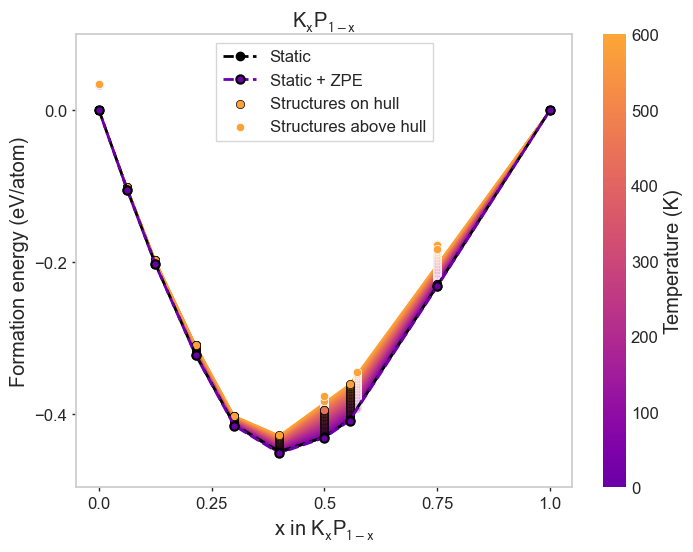

In [7]:
td_hull.plot_hull(plot_points=True)

In [10]:
hull_dists = []
labels = []
for doc in td_hull.cursor:
    if doc['stoichiometry'] == [["K", 3.0], ["P", 1.0]]:
        hull_dists.append(doc["temperature"]["hull_distance"])
        labels.append(doc['source'][0].split('/')[-1])

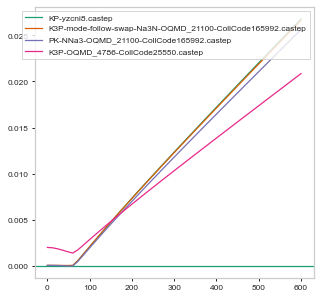

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(facecolor="w", figsize=(5, 5))

ax.axhline(0)
for ind, hull_dist in enumerate(hull_dists):
    ax.plot(td_hull.cursor[0]["temperature"]["temperatures"], hull_dist, label=labels[ind])
ax.legend()

In [17]:
import numpy as np
_cursor = copy.deepcopy(cursor)
temps = np.linspace(0, 800, 21)
for ind, doc in enumerate(cursor):
    _cursor[ind]["temperature"] = {}
    _doc = VibrationalDOS(doc)
    temps, vibs = _doc.vibrational_free_energy(temperatures=temps)
    _cursor[ind]["temperature"]["free_energy_per_atom"] = np.ones_like(temps) * _cursor[ind]["total_energy_per_atom"]
    _cursor[ind]["temperature"]["free_energy_per_atom"] += vibs
    _cursor[ind]["temperature"]["temperatures"] = temps

In [18]:
ens_hull = EnsembleHull(
    cursor=_cursor,
    energy_key="free_energy_per_atom",
    chempot_energy_key="total_energy_per_atom", 
    parameter_key="temperatures",
    data_key="temperature",
    quiet=True,
    num_samples=21,
)

100%|██████████| 21/21 [00:00<00:00, 941.17it/s]

10 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                Source                 !?!  Pressure  Cell volume      Hull dist.      Space group      Formula      # fu   Prov.  
                                             (GPa)      (Å³/fu)        (meV/atom)    
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* K-CollCode44670                               0.02         73.3           0.0           Im-3m            K          1      ICSD  
* KP-yzcni8                                     0.00        145.5           0.0          Pmn2_1           K3P         4     AIRSS  
* KP-NaP-CollCode56530                          0.00        267.9           0.0           C2/m           K5P4         1     SWAPS  
* KP-OQMD_2818-CollCode14010                

In [27]:
ens_hull.chempot_cursor[0]["temperature"]["temperatures"]

array([  0.,  40.,  80., 120., 160., 200., 240., 280., 320., 360., 400.,
       440., 480., 520., 560., 600., 640., 680., 720., 760., 800.])

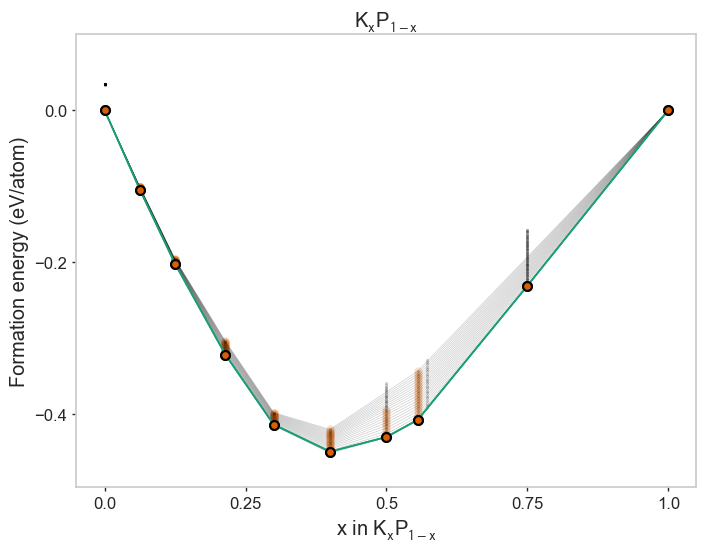

In [19]:
ens_hull.plot_hull(plot_points=True, )

10 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                Source                 !?!  Pressure  Cell volume      Hull dist.      Space group      Formula      # fu   Prov.  
                                             (GPa)      (Å³/fu)        (meV/atom)    
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* K-CollCode44670                               0.02         73.3           0.0           Im-3m            K          1      ICSD  
* KP-yzcni8                                     0.00        145.5           0.0          Pmn2_1           K3P         4     AIRSS  
* KP-NaP-CollCode56530                          0.00        267.9           0.0           C2/m           K5P4         1     SWAPS  
* KP-OQMD_2818-CollCode14010                

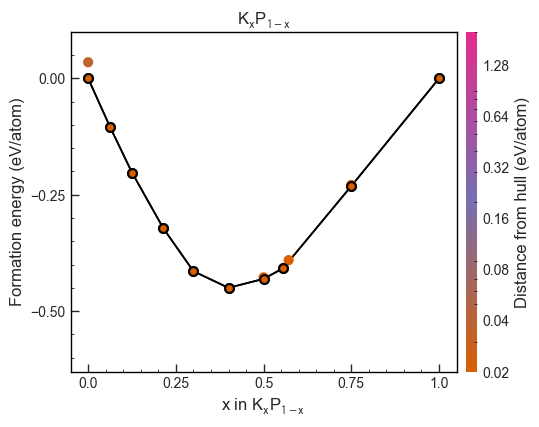

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                Source                 !?!  Pressure  Cell volume      Hull dist.      Space group      Formula      # fu   Prov.  
                                             (GPa)      (Å³/fu)        (meV/atom)    
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* K-CollCode44670                               0.02         73.3           0.0           Im-3m            K          1      ICSD  
* KP-yzcni8                                     0.00        145.5           0.0          Pmn2_1           K3P         4     AIRSS  
* KP-NaP-CollCode56530                          0.00        267.9           0.0           C2/m           K5P4         1     SWAPS  
* KP-OQMD_2818-CollCode14010                    0.00         57.5           0.0        P2_12_12_1         KP          8   

In [48]:
QueryConvexHull(cursor=_cursor, energy_key="total_energy_per_atom", species="KP")

#### Materials project PBE results

In [ ]:
# grab some materials project data too
import pickle
with open('/home/mevans/proj/aalto/notebooks/mp_KP.pickle', 'rb') as f:
    mp_cursor = pickle.load(f)
# temp fix for outdated data
for doc in mp_cursor:
    doc['cell_volume'] = 1
mp_hull = QueryConvexHull(cursor=mp_cursor, species='KP', chempots=[0, 0], subcmd='voltage', no_plot=True)

#### OQMD PBE results, with FERE corrections

In [ ]:
query = DBQuery(composition='KP', db='oqmd', subcmd='voltage')
oqmd_hull = QueryConvexHull(query, subcmd='voltage', species='KP')

#### Comparison of voltages & hulls

In [ ]:
fig, ax = plt.subplots()
pbe_hull.args['label_cutoff'] = None
scan_hull.args['label_cutoff'] = None
plot_voltage_curve(scan_hull.voltage_data, ax=ax, show=False, curve_labels='rSCAN', line_kwargs=dict(ls='-.', c=scan_hull.colours[0]))
plot_voltage_curve(pbe_hull.voltage_data, ax=ax, show=False, curve_labels='PBE', line_kwargs=dict(ls='-.', c=scan_hull.colours[1]))
plot_voltage_curve(mp_hull.voltage_data, ax=ax, show=False, curve_labels='Materials Project', line_kwargs=dict(ls='-.', c=scan_hull.colours[2]))
plot_voltage_curve(oqmd_hull.voltage_data, ax=ax, show=False, curve_labels='OQMD', line_kwargs=dict(ls='-.', c=scan_hull.colours[3]))
_ = ax.legend()

In [ ]:
from matador.plotting.hull_plotting import plot_2d_hull
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
pbe_hull.args['label_cutoff'] = None
# hack colours for now
pbe_hull.colours = scan_hull.colours[1:]
mp_hull.colours = scan_hull.colours[2:]
oqmd_hull.colours = scan_hull.colours[3:]
plot_2d_hull(pbe_hull, ax=ax, show=False, label_offset=(0.01, 0.1), labels=True, plot_points=False, hull_label='PBE')
plot_2d_hull(mp_hull, ax=ax, show=False,  plot_points=False, hull_label='Materials Project')
plot_2d_hull(oqmd_hull, ax=ax, show=False, plot_points=False, hull_label='OQMD')
plot_2d_hull(scan_hull, ax=ax, show=False, plot_points=False, hull_label='rSCAN')
_ = ax.legend(loc='upper center')

## Finite temperature hulls

In [ ]:
from matador.hull.hull_temperature import TemperatureDependentHull

In [ ]:
cursor, failures = castep2dict("/home/mevans/proj/KPX/K+P/")
TemperatureDependentHull()

## BEEF hulls

#### PBE-based BEEF in CASTEP

In [ ]:
fname = 'pickled_beef.pickle'
import pickle
import os
if os.path.isfile(fname):
    print('Loading pickled cursor.')
    with open(fname, 'rb') as f:
        beef_cursor = pickle.load(f)
else:
    files = glob.glob('/u/fs1/me388/proj/KPX/K+P/KP-650-0.02-1.75-1.75-PBE-OTF-0.01-BEEF/completed/*.castep')
    beef_cursor = []
    for f in tqdm.tqdm(files):
        doc, s = castep2dict(f, db=False, verbosity=10)
        if not s:
            raise s
        beef_cursor.append(doc)
    with open(fname, 'wb') as f:
        pickle.dump(beef_cursor, f)

In [ ]:
beef_hull = EnsembleHull(beef_cursor, '_beef', 'total_energy_per_atom', num_samples=500, species='KP')

In [ ]:
beef_hull.plot_hull(plot_points=False)

In [ ]:
from matador.utils.chem_utils import get_stoich_from_formula
from matador.utils.chem_utils import get_concentration
stability_hist = beef_hull.generate_stability_statistics(group_by='formula')
print(stability_hist)
plt.bar([get_concentration(get_stoich_from_formula(key), ['K', 'P'])[0] for key in stability_hist], 
        [stability_hist[key] for key in stability_hist], 0.01)

#### GPAW mBEEF-vdW

In [ ]:
gpaw_files = glob.glob('/u/fs1/me388/proj/KPX/K+P/*GPAW*/beef_test/completed/*.beef.out')
import numpy as np
from matador.utils.chem_utils import get_stoich
gpaw_cursor = []
for f in tqdm.tqdm(gpaw_files):
    doc = {}
    doc['source'] = [f.split('/')[-1].replace('.beef.out', '.res')]
    doc['_beef'] = {}
    doc['_beef']['total_energy'] = np.loadtxt(f)
    with open(f.replace('beef.out', 'gpaw.out'), 'r') as _f:
        flines = _f.readlines()
    for ind, line in enumerate(flines):
        if 'Free energy' in line:
            doc['free_energy'] = float(flines[ind].split()[-1])
            doc['total_energy'] = float(flines[ind+1].split()[-1])
        if 'Number of atoms' in line:
            doc['num_atoms'] = int(line.split()[-1])
        if 'Positions:' in line:
            doc['atom_types'] = []
            i = ind + 1
            while flines[i].strip():
                doc['atom_types'].append(flines[i].split()[1])
                i += 1
    doc['stoichiometry'] = get_stoich(doc['atom_types'])
    doc['num_fu'] = len(doc['atom_types']) / sum([atom[1] for atom in doc['stoichiometry']])
    doc['free_energy_per_atom'] = doc['free_energy'] / doc['num_atoms']
    doc['total_energy_per_atom'] = doc['total_energy'] / doc['num_atoms']
    doc['_beef']['total_energy_per_atom'] = (doc['_beef']['total_energy'] / doc['num_atoms']).tolist()
    doc['_beef']['total_energy'] = doc['_beef']['total_energy'].tolist()
    gpaw_cursor.append(doc)

In [ ]:
mbeef_hull = EnsembleHull(gpaw_cursor, '_beef', 'total_energy_per_atom', species='KP', num_samples=2000)

In [ ]:
mbeef_hull.plot_hull(plot_points=False)

In [ ]:
from matador.utils.chem_utils import get_stoich_from_formula
from matador.utils.chem_utils import get_concentration
stability_hist = mbeef_hull.generate_stability_statistics(group_by='formula')
print(stability_hist)
plt.bar([get_concentration(get_stoich_from_formula(key), ['K', 'P'])[0] for key in stability_hist], 
        [stability_hist[key] for key in stability_hist], 0.01)

### Messing with chemical potentials

#### Modify P chempot

In [ ]:
import numpy as np
query = DBQuery(composition='KP', geom_force_tol=0.01, db='me388_KSnP', subcmd='hull', no_plot=True)
hull = QueryConvexHull(query)
new_cursor = hull.cursor
space = np.linspace(-0.5, 0.5, 100)
for doc in new_cursor:
    doc['_variable_mu'] = {}
    if doc['stoichiometry'] == [['P', 1]]:
        doc['_variable_mu']['enthalpy_per_atom'] = (space + doc['enthalpy_per_atom']).tolist()
    else:
        doc['_variable_mu']['enthalpy_per_atom'] = (np.ones_like(space) * doc['enthalpy_per_atom']).tolist()

mu_hull = EnsembleHull(new_cursor, '_variable_mu', species='KP')
mu_hull.plot_hull(plot_points=False, alpha_scale=0.06)

#### Varying K chemical potential

In [ ]:
import numpy as np
query = DBQuery(composition='KP', geom_force_tol=0.01, db='me388_KSnP', subcmd='hull', no_plot=True)
hull = QueryConvexHull(query)
new_cursor = hull.cursor
space = np.linspace(-0.5, 0.5, 100)
for doc in new_cursor:
    doc['_variable_mu'] = {}
    if doc['stoichiometry'] == [['K', 1]]:
        doc['_variable_mu']['enthalpy_per_atom'] = (space + doc['enthalpy_per_atom']).tolist()
    else:
        doc['_variable_mu']['enthalpy_per_atom'] = (np.ones_like(space) * doc['enthalpy_per_atom']).tolist()

mu_hull = EnsembleHull(new_cursor, '_variable_mu', species='KP')
mu_hull.plot_hull(plot_points=False, alpha_scale=0.06)

In [ ]:
from matador.crystal import Crystal
crystals = []
for doc in oqmd_hull.cursor:
    try:
        crystals.append(Crystal(doc))
    except:
        pass
pxrds = []
for crystal in tqdm.tqdm(crystals):
    pxrds.append(crystal.pxrd)

In [ ]:
from matador.plotting import plot_pxrd
plot_pxrd(pxrds)

In [ ]:
pbe_crystals = []
for doc in pbe_hull.cursor:
    if doc['hull_distance'] < 0.02:
        pbe_crystals.append(Crystal(doc))

In [ ]:
for doc in pbe_crystals:
    if doc.formula == 'K5P4':
        plot_pxrd([doc.pxrd], figsize=(8, 5))
    elif doc.formula == 'K4P3':
        plot_pxrd([doc.pxrd], figsize=(8, 5))

In [ ]:
query = DBQuery(composition='KSn', db='mp_2019_subset', subcmd='hull', kpoint_tolerance=0.1)
mp_hull = QueryConvexHull(query, no_plot=False)
query = DBQuery(composition='KSn', db='me388_KSnP_final', geom_force_tol=0.0001, subcmd='hull', kpoint_tolerance=0.1)
matador_hull = QueryConvexHull(query, no_plot=False)

In [ ]:
from matador.plotting.hull_plotting import plot_2d_hull
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
# hack colours for now
mp_hull.colours = matador_hull.colours[2:]
plot_2d_hull(mp_hull, ax=ax, show=False, plot_points=True, hull_label='Materials Project')
plot_2d_hull(matador_hull, ax=ax, show=False, plot_points=True, hull_label='me')
_ = ax.legend(loc='upper center')